## Noisy RGB pixels + Albedo + Normal, Conv + ResUNet + Conv, Fit Residual, L1+L2 loss, 1/8 U-Net bottleneck

In [6]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def matrix_transform(mat, p):
    x = np.einsum('ij,jxy->ixy', mat[:3,:3], p)
    x += mat[:3, 3, np.newaxis, np.newaxis]
    x /= np.fmax(np.einsum('i,ixy->xy', mat[3,:3], p) + mat[3][3], 1e-6)
    return x

def process_position(position, mat):
    x = matrix_transform(mat, position)
    x = x[2:]
    x = np.clip(x, -1.0, 1.0)
    x = (x-np.mean(x)) / np.var(x)**0.5
    return x

def process_normal(normal, mat):
    # return np.einsum('ij,jxy->ixy', mat[:3,:3], normal)
    ro_s = np.array([*np.meshgrid(
        (np.arange(normal.shape[1])+0.0)/normal.shape[1],
        (np.arange(normal.shape[2])+0.0)/normal.shape[2]
    ), np.zeros(normal[0].shape)]).astype(np.float32)
    imat = np.linalg.inv(mat)
    ro = matrix_transform(imat, ro_s)
    def transform_rd(w):
        w = np.array(w)[:,np.newaxis,np.newaxis]
        r = matrix_transform(imat, ro_s+w)-ro
        r /= np.linalg.norm(r, axis=0)[np.newaxis, :, :]
        return r
    rd = transform_rd([0, 0, 1])
    ru = transform_rd([1, 0, 0])
    rv = transform_rd([0, 1, 0])
    n = np.einsum('ijxy,jxy->ixy', [ru, rv, rd], normal)
    return n


def load_data_file(filename, verbose=False):
    data = np.fromfile('data/'+filename, dtype=np.float32)
    n, w, h = map(int, filename[filename.find('_')+1:filename.find('.')].split('_'))
    mat = data[:16].reshape((4, 4))
    # mat = np.linalg.inv(mat).T
    data = data[16:].reshape((n, 3, w, h))
    position, normal, albedo = data[:3]
    normal = process_normal(normal, mat)
    depth = process_position(position, mat)
    if verbose:
        plot_frame(albedo)
        plot_frame(0.5+0.5*normal)
        plot_frame(0.5+0.5*depth)
    data = data[3:]
    n = n - 3
    ref = np.zeros((3, w, h), dtype=np.float32)
    weights = np.zeros((3, w, h), dtype=np.float32)
    for i in range(n):
        frame = data[i]
        dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**i
        ref += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
        weights += dw
        if (n-i) % 4 == 1 and verbose:
            print(2**i, 'spp')
            plot_frame(frame**(1.0/2.2))
    ref /= np.fmax(weights, 1)
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        # x = np.clip(x, 0.0, 1.0)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2
    if verbose:
        print("converged")
        plot_frame(ref**(1.0/2.2))
    aux = np.concatenate((albedo, normal, depth)).astype(np.float32)
    aux = np.nan_to_num(aux, nan=0.0, posinf=1.0, neginf=-1.0)
    return {
        'w': w,
        'h': h,
        'aux': aux,
        'data': data,
        'ref': ref
    }


torch.Size([8, 3, 256, 256])


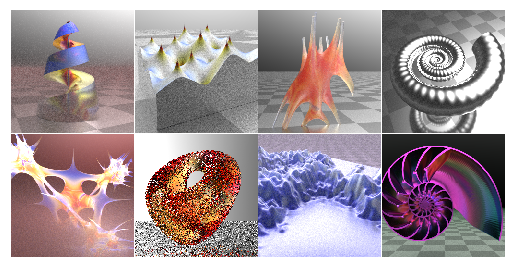

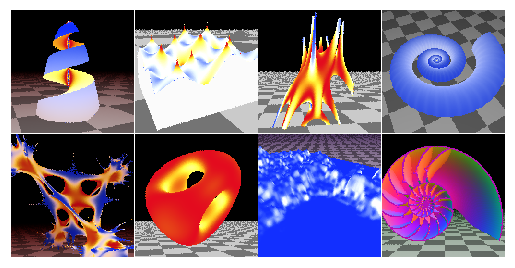

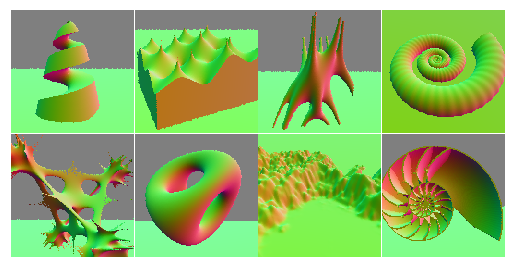

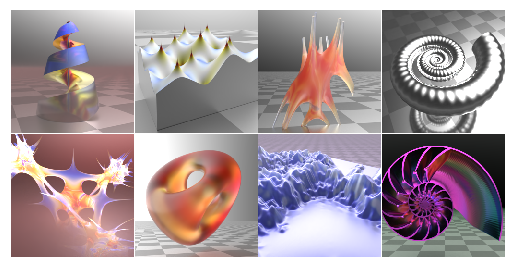

In [8]:
class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = [load_data_file(filename) for filename in os.listdir("data/")]
        s = 256
        self.n = n
        self.s = s
        self.coords = []
        for i in range(n):
            k = np.random.randint(0, len(self.data))
            x = np.random.randint(0, self.data[k]['w']-s+1)
            y = np.random.randint(0, self.data[k]['h']-s+1)
            self.coords.append((k, x, y))

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        k, x, y = self.coords[i]
        s = self.s
        n = self.data[k]['data'].shape[0]
        total = np.zeros((3, s, s), dtype=np.float32)
        weights = np.zeros((3, s, s), dtype=np.float32)
        spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
        for _ in range(n):
            if (spp >> _) & 1 == 0:
                continue
            frame = self.data[k]['data'][_, :, x:x+s, y:y+s]
            dw = ((frame > 0.0) & (frame < 1e4)).astype(np.float32) * 2**_
            total += np.nan_to_num(frame, nan=0.0, posinf=0.0, neginf=0.0) * dw
            weights += dw
        return [
            np.fmax(total / np.fmax(weights, 1), 0.0) ** (1.0/2.2),
            self.data[k]['aux'][:, x:x+s, y:y+s],
            np.fmax(self.data[k]['ref'][:, x:x+s, y:y+s], 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, a, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(a[:, 0:3])
plot_imgs(a[:, 3:6]*0.5+0.5)
# plot_imgs(a[:, 6:7]*0.5+0.5)
plot_imgs(y)

In [9]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(11, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 3)

    def forward(self, input):
        ci = self.convi(input)
        e0 = self.econv0b(relu(self.econv0a(relu(ci)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.convo(ci+do)


model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(11, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(1, 1

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
)
128 0.2792309820652008
256 0.1509455293416977
384 0.07759680598974228
512 0.08529984951019287
640 0.1313396394252777
768 0.08433791995048523
896 0.1303064227104187
1024 0.04084368795156479
1152 0.04053713008761406
1280 0.09636235982179642
1408 0.07314465194940567
1536 0.039316676557064056
1664 0.06269825994968414
1792 0.026855874806642532
1920 0.033643629401922226
2048 0.05599277466535568


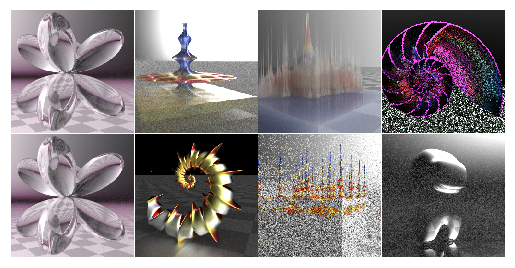

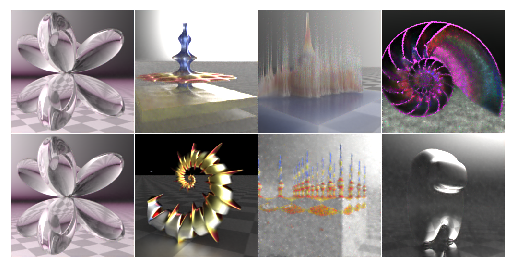

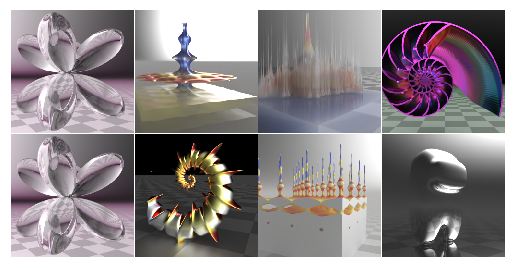

2176 0.04656436666846275
2304 0.027783939614892006
2432 0.06572273373603821
2560 0.03924551233649254
2688 0.026631921529769897
2816 0.08384594321250916
2944 0.08074884861707687
3072 0.03220328688621521
3200 0.03544322028756142
3328 0.03823813796043396
3456 0.056718580424785614
3584 0.03852976858615875
3712 0.06181339919567108
3840 0.02588752843439579
3968 0.09886956214904785
4096 0.05227798968553543


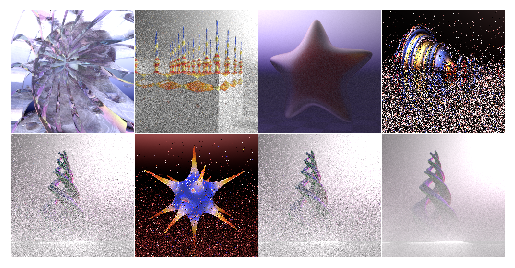

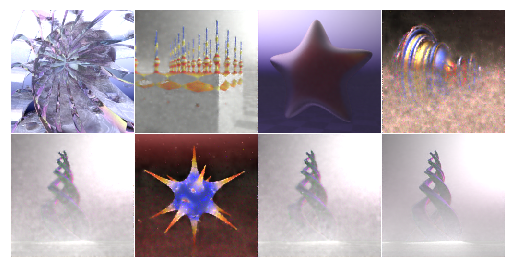

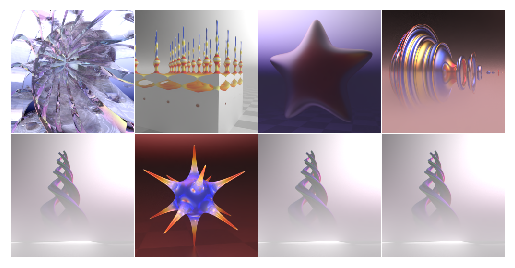

4224 0.05093993619084358
4352 0.057355765253305435
4480 0.02963218092918396
4608 0.0493992380797863
4736 0.031870849430561066
4864 0.03985271230340004
4992 0.029675830155611038
5120 0.053093306720256805
5248 0.03176765888929367
5376 0.06492869555950165
5504 0.05028407275676727
5632 0.034478094428777695
5760 0.030215168371796608
5888 0.05626126378774643
6016 0.08684216439723969
6144 0.06717824190855026


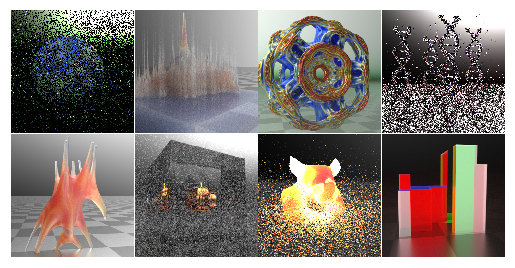

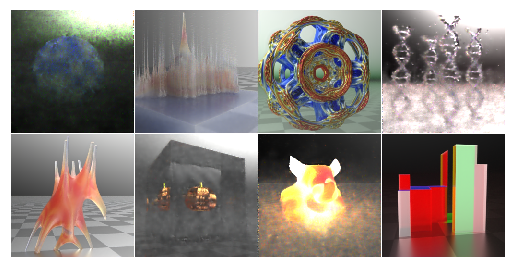

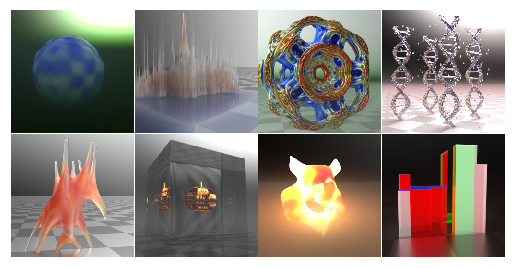

6272 0.02558950148522854
6400 0.053486380726099014
6528 0.058708786964416504
6656 0.04178863391280174
6784 0.05223560333251953
6912 0.0398145392537117
7040 0.07630187273025513
7168 0.048862263560295105
7296 0.052052147686481476
7424 0.060020677745342255
7552 0.019946034997701645
7680 0.0646129697561264
7808 0.05111423134803772
7936 0.03283405303955078
8064 0.022933054715394974
8192 0.04862423241138458


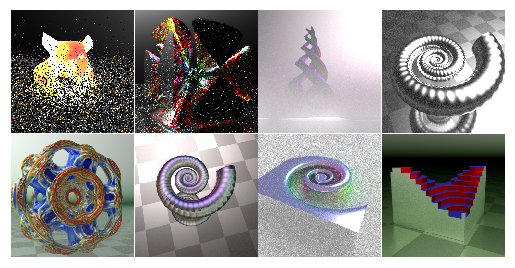

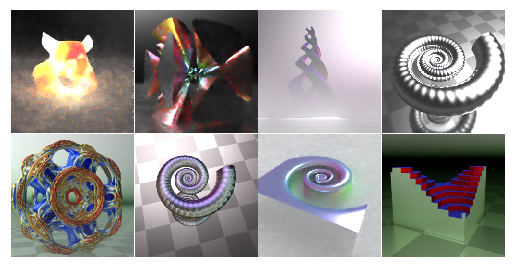

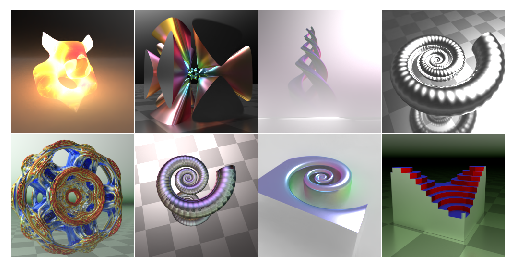

8320 0.031800948083400726
8448 0.04315967485308647
8576 0.016013210639357567
8704 0.03310901299118996
8832 0.027453908696770668
8960 0.026014458388090134
9088 0.06360047310590744
9216 0.0375501774251461
9344 0.02604673244059086
9472 0.07036980241537094
9600 0.031023358926177025
9728 0.04700680822134018
9856 0.0318215936422348
9984 0.03258344531059265
10112 0.030052263289690018
10240 0.0406348779797554


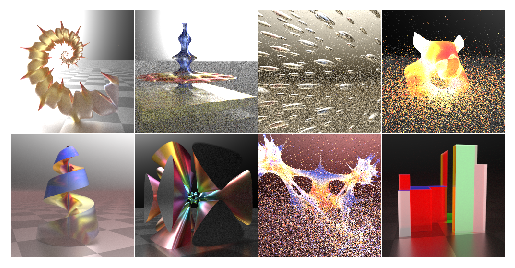

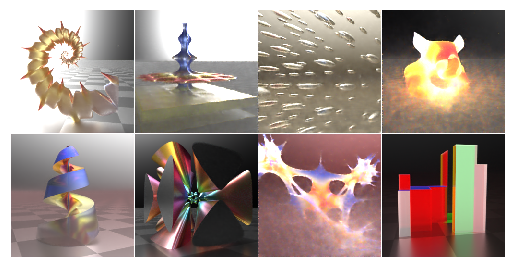

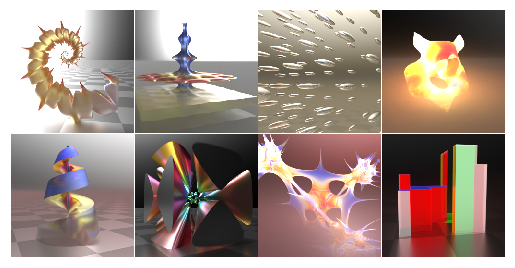

10368 0.055491313338279724
10496 0.032168105244636536
10624 0.06161297857761383
10752 0.0418248251080513
10880 0.04680942744016647
11008 0.05169019103050232
11136 0.03475875407457352
11264 0.06013331934809685
Epoch 00088: reducing learning rate of group 0 to 1.0000e-04.
11392 0.028972357511520386
11520 0.05412173643708229
11648 0.02158816158771515
11776 0.041244883090257645
11904 0.03652020916342735
12032 0.026089968159794807
12160 0.0430808886885643
12288 0.03578338772058487


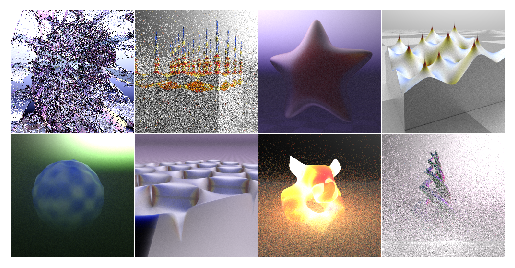

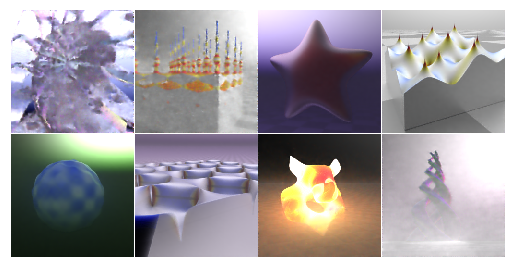

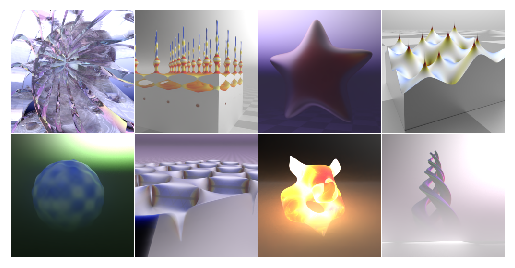

12416 0.03968536853790283
12544 0.07343031466007233
12672 0.047216832637786865
12800 0.0176473967730999
12928 0.06500309705734253
13056 0.04902057349681854
13184 0.02986932173371315
13312 0.0478891022503376
13440 0.04100082814693451
13568 0.038750916719436646
13696 0.042068902403116226
13824 0.04169868677854538
13952 0.041645776480436325
Epoch 00109: reducing learning rate of group 0 to 1.0000e-05.
14080 0.04162002354860306
14208 0.04816165938973427
14336 0.044481366872787476


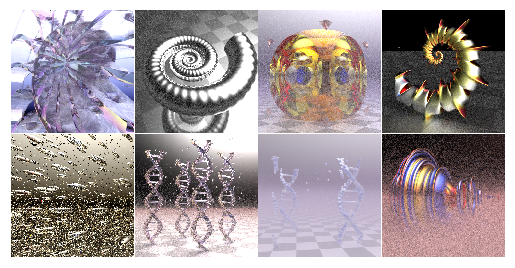

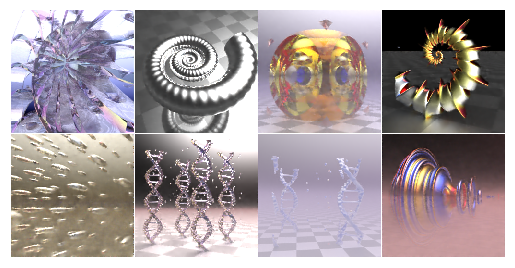

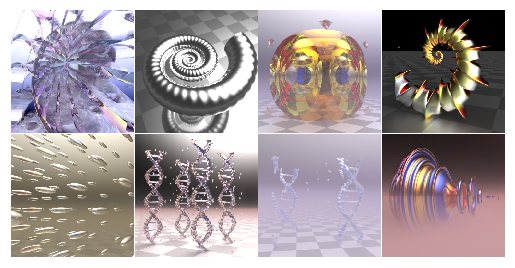

14464 0.03210427239537239
14592 0.016018681228160858
14720 0.0936017781496048
14848 0.03670559823513031
14976 0.037525475025177
15104 0.023424703627824783
15232 0.023003585636615753
15360 0.04126681387424469
15488 0.03619176149368286
15616 0.046336591243743896
15744 0.03145751357078552
15872 0.02635044790804386
16000 0.022338658571243286
16128 0.06573274731636047
16256 0.0494513213634491
16384 0.03896377980709076


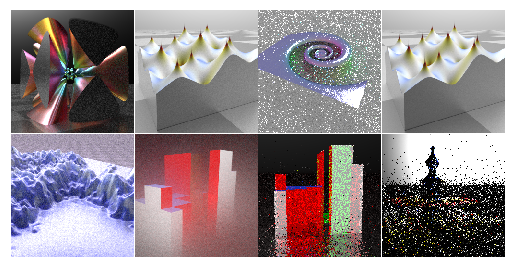

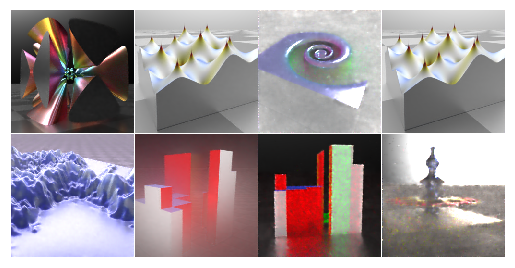

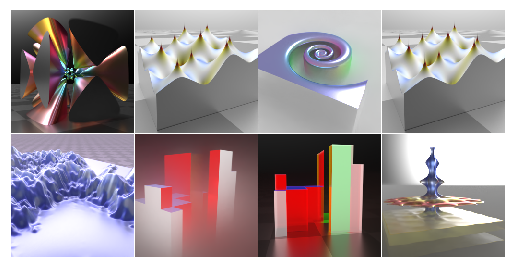

16512 0.02091185748577118
16640 0.057079069316387177
Epoch 00130: reducing learning rate of group 0 to 1.0000e-06.
16768 0.04289954528212547
16896 0.04173841327428818
17024 0.024194203317165375
17152 0.027547691017389297
17280 0.04707712680101395
17408 0.0403626412153244
17536 0.046466805040836334
17664 0.014347165822982788
17792 0.017280589789152145
17920 0.04698162153363228
18048 0.029159851372241974
18176 0.04375291243195534
18304 0.04413319379091263
18432 0.027393382042646408


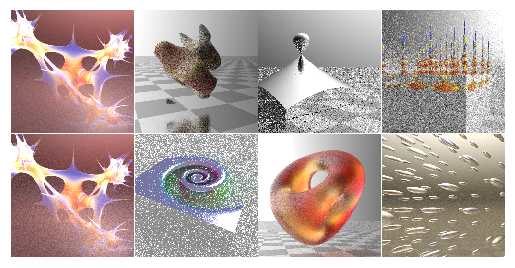

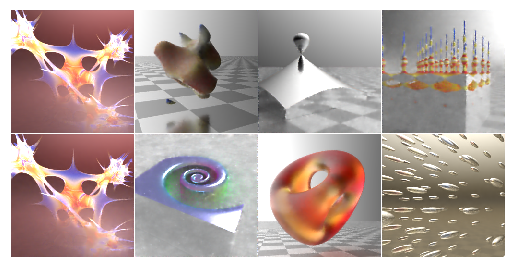

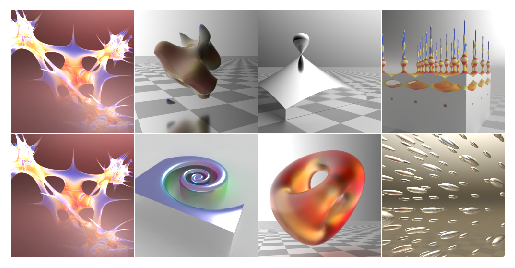

18560 0.023577231913805008
18688 0.04774051904678345
18816 0.03394293040037155
18944 0.014076046645641327
19072 0.024000145494937897
19200 0.033465493470430374
19328 0.03179149702191353
19456 0.016855716705322266
19584 0.04397151991724968
19712 0.03734142333269119
19840 0.02500895969569683
19968 0.0149045679718256
20096 0.044483624398708344
20224 0.04428590089082718
20352 0.04367309808731079
20480 0.03759152069687843


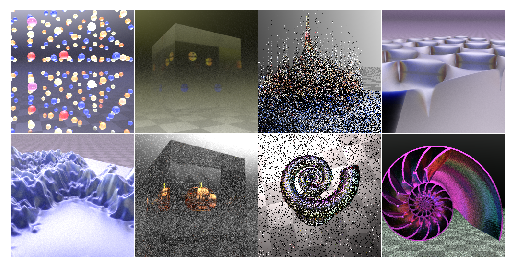

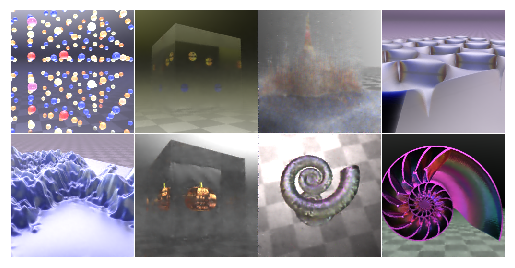

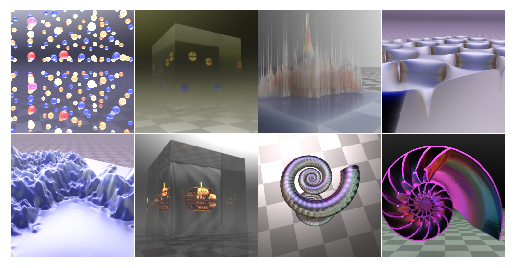

20608 0.0809093490242958
20736 0.036046840250492096
20864 0.053651124238967896
20992 0.03940668702125549
21120 0.02019200101494789
21248 0.028837352991104126
21376 0.03434283658862114
21504 0.05247855186462402
21632 0.02608092688024044
Epoch 00169: reducing learning rate of group 0 to 1.0000e-07.


In [10]:
import torchvision.models
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
vgg16_features = vgg16.features
vgg16_head = vgg16_features[:4].to(device)
for param in vgg16_head:
    param.requires_grad = False
print(vgg16_head)

def color_norm(c):
    return (c[:,0:1]**2 + c[:,1:2]**2 + c[:,2:3]**2) ** 0.5

def lossfun(output, reference):
    l1 = torch.mean(torch.abs(output-reference))
    l2 = torch.mean((output-reference)**2) / 0.05
    output1 = vgg16_head(output)
    reference1 = vgg16_head(reference)  # to do: can be precomputed
    lp = torch.mean(torch.abs(output1-reference1))
    return l1 + l2 + lp

model_params = torch.cat([x.view(-1) for x in model.parameters()])

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=20, min_lr=0.0, verbose=True)


batch_count = 0
terminate = False
for epoch in range(2):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=8, shuffle=True)
    for x, a, y in trainloader:
        x = x.to(device)
        a = a.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)
        optimizer.zero_grad()
        m_in = torch.concatenate((
            a[:,0:3], color_norm(a[:,0:3]), # albedo
            a[:,3:6], a[:,3:4]**2+a[:,4:5]**2,  # normal
            x,  # pixels
            ), axis=1)
        output = model(m_in)
        torch.mean(torch.abs(output))
        loss = lossfun(output, y-x)
        loss.backward()
        # regl1 = 0.0 * torch.mean(torch.abs(model_params))
        # regl2 = 1.0 * torch.mean((model_params)**2)
        # (regl1+regl2).backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 128 == 0:
            print(batch_count, loss.item())
            scheduler.step(loss)
            if optimizer.param_groups[0]['lr'] < 1e-6:
                terminate = True
                break
        if batch_count % 2048 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp((output+x).detach())-1)
            plot_imgs(torch.exp(y)-1)
            model_path = "model5anc_small.pth"
            torch.save(model, model_path)
    if terminate:
        break

torch.save(model, model_path)
